In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize']=6,6

/Users/shrikararchak/Anaconda/anaconda/envs/ds/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df = pd.read_csv('dataset/kickstarter/train.csv')

In [3]:
df.head()

,project_id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,backers_count,final_status
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,20.0,drawing-for-dollars,False,US,USD,1241333999,1241334017,1240600507,1240602723,3,1
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",300.0,sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,USD,1242429000,1242432018,1240960224,1240975592,2,0
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,30.0,mr-squiggles,False,US,USD,1243027560,1243027818,1242163613,1242164398,0,0
3,kkst597742710,Help me write my second novel.,Do your part to help out starving artists and ...,500.0,help-me-write-my-second-novel,False,US,USD,1243555740,1243556121,1240963795,1240966730,18,1
4,kkst1913131122,Support casting my sculpture in bronze,"I'm nearing completion on a sculpture, current...",2000.0,support-casting-my-sculpture-in-bronze,False,US,USD,1243769880,1243770317,1241177914,1241180541,1,0


### Create a text column includes name, desc and the keywords.
We will be using this field for generating text features for our classification algorithm

In [4]:
df['all_text'] = df['name'] + " "+ df['desc'] +" "+ df['keywords'].apply(lambda x: x.replace('-', ' '))

In [5]:
### Distribution of kickstarter projects by country

### Distribution of kickstarter projects by country

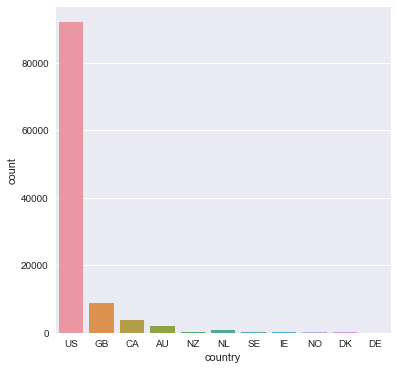

In [6]:
sns.countplot(x='country', data= df)

In [7]:
aggregated = df.groupby(['country','final_status']).size().reset_index().rename(columns={0: 'proj_counts'})

In [8]:
by_projects = aggregated.groupby(['country','final_status']).agg({'proj_counts': 'sum'})

In [9]:
pct_projects = by_projects.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index().rename(columns={'proj_counts': 'final_status_pct'})

### Distribution of success/failure of a project by countries

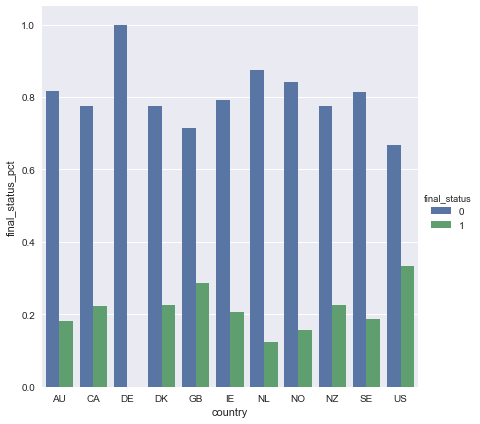

In [10]:
sns.factorplot(x='country', y='final_status_pct', hue='final_status', data=pct_projects, kind='bar', size=6)

### Distribution of the top goal amount in a kickstarter project.

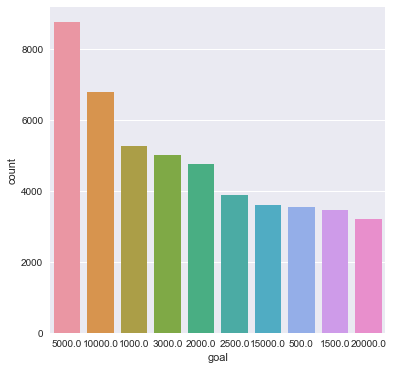

In [11]:
sns.countplot(x='goal', data=df[df['goal'] < 50000], order=df.goal.value_counts().iloc[:10].index)

In [12]:
df.columns

Index(['project_id', 'name', 'desc', 'goal', 'keywords',
       'disable_communication', 'country', 'currency', 'deadline',
       'state_changed_at', 'created_at', 'launched_at', 'backers_count',
       'final_status', 'all_text'],
      dtype='object')

In [13]:
df['duration'] = ((df['deadline'] - df['launched_at'])/86400.0).astype(int)

In [14]:
df['days_status_changed'] = ((df['deadline'] - df['state_changed_at'])/86400.0).astype(int)

In [15]:
df['country'] = pd.Categorical(df.country)
df['currency'] = pd.Categorical(df.currency)
df['country_int'] = df.country.cat.codes
df['currency_int'] = df.currency.cat.codes

In [16]:
from nltk.corpus import stopwords
cachedStopWords = stopwords.words('english')

# Function for removing stop words from a string
def removeStopwords(s):
    return ' '.join([word for word in s.split() if word not in cachedStopWords])

# Function for cleaning the reviews
def cleanText(s):
    s = str(s).lower()                         # Convert to lowercase
    s = s.replace(r'<.*?>', ' ')          # Remove HTML characters
    s = s.replace('"', '')               # Remove single quotes ' 
    s = s.replace('\'', '')               # Remove single quotes ' 
    s = s.replace('-', '')                # Remove dashes -
    s = s.replace(r'[^a-zA-Z]', ' ')      # Remove non alpha characters
    s = s.strip()                         # Remove whitespace at start and end
    s = re.sub(r'[^\w\s]','',s)
    return s

In [17]:
import string
import re

In [18]:
df['cleaned_text'] = df['all_text'].apply(lambda x: cleanText(x))

In [19]:
df[['cleaned_text', 'goal', 'duration', 'final_status']].head()

,cleaned_text,goal,duration,final_status
0,drawing for dollars i like drawing pictures an...,20.0,8,1
1,sponsor dereck blackburn lostwars artist in re...,300.0,16,0
2,mr squiggles so i saw darkponys successfully f...,30.0,9,0
3,help me write my second novel do your part to ...,500.0,29,1
4,support casting my sculpture in bronze im near...,2000.0,29,0


In [20]:
features = ['goal', 'disable_communication', 'country_int', 'currency_int', 'duration', 'days_status_changed', 'backers_count', 'cleaned_text']

In [21]:
int_features = ['goal', 'disable_communication', 'country_int', 'currency_int', 'duration', 'days_status_changed', 'backers_count']

In [22]:
from sklearn.cross_validation import train_test_split
X = df[features]
y = df['final_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

/Users/shrikararchak/Anaconda/anaconda/envs/ds/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:

from sklearn.base import BaseEstimator, TransformerMixin

In [24]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return [x[0] for x in data_dict[self.keys].values.tolist()]

class IntItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.keys].astype(float).values
    
t = ItemSelector(['cleaned_text'])


In [39]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [58]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('pipeline', Pipeline([
                ('selector', ItemSelector(['cleaned_text'])),
                ('vect', TfidfVectorizer(stop_words='english', min_df=5, max_df=50))
            ])),
            
            #Pipeline for pulling ad hoc features from post's body
            ('integer_features', Pipeline([('fts', IntItemSelector(int_features))])),
        ]
    )),

    # Use a SVC classifier on the combined features
#     ('svc', SVC(random_state=12, kernel='linear', probability=True, class_weight='balanced')),
#      ('clf', LogisticRegression())
      ('clf', RandomForestClassifier(n_estimators=100))
])


In [59]:
pipeline.fit(X_train, y_train)
from sklearn.metrics import confusion_matrix
predicted = pipeline.predict(X_test)
print(np.mean(predicted == y_test))
print(confusion_matrix(y_test, predicted))
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))

0.856582695224
[[16589  1826]
 [ 2051  6567]]
             precision    recall  f1-score   support

          0       0.89      0.90      0.90     18415
          1       0.78      0.76      0.77      8618

avg / total       0.86      0.86      0.86     27033



In [45]:
parameters = {'union__pipeline__vect__ngram_range': [(1, 1), (1, 2), (1,3)],
              'union__pipeline__vect__use_idf': (True, False),
              'clf__C': (1e-2, 1e-3, 0.1, 1, 10),
}

gs_clf = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
gs_clf = gs_clf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.0min finished


In [47]:
from sklearn.metrics import confusion_matrix
predicted = gs_clf.predict(X_test)
print(np.mean(predicted == y_test))
print(confusion_matrix(y_test, predicted))
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))

0.826360374357
[[17430   985]
 [ 3709  4909]]
             precision    recall  f1-score   support

          0       0.82      0.95      0.88     18415
          1       0.83      0.57      0.68      8618

avg / total       0.83      0.83      0.82     27033



In [61]:
df.final_status.value_counts()

0    73568
1    34561
Name: final_status, dtype: int64

In [62]:
(73568)/(73568+34561)

0.6803725180108944